In [1]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from mordred import Calculator, descriptors

# 1. Nhập dữ liệu

In [2]:
test_dataset = pd.read_csv("../data_for_modeling/filter_data/v1/HDAC2_test.csv")
train_dataset = pd.read_csv("../data_for_modeling/filter_data/v1/HDAC2_train.csv")

# 2. Xây dựng mô hình với Modred descriptors

## 2.1. Tính toán mordred descriptors

__Mã hóa cấu trúc phân tử bằng Modred descriptors__

In [3]:
# def process_modred(data):
#     calc = Calculator(descriptors, ignore_3D=True)
#     mols = [Chem.MolFromSmiles(smi) for smi in data]
#     # pandas df
#     df = calc.pandas(mols)
#     return df

# train_modred_descriptors = process_modred(train_dataset['SMILES'])
# test_mordred_descriptors = process_modred(test_dataset['SMILES'])

In [134]:
train_modred_descriptors = pd.read_excel('../data_for_modeling/filter_data/v1/modred_descriptors_out.xlsx', sheet_name="train_modred_descriptors")
test_mordred_descriptors = pd.read_excel('../data_for_modeling/filter_data/v1/modred_descriptors_out.xlsx', sheet_name="test_modred_descriptor")

In [135]:
train_modred_descriptors = pd.DataFrame(train_modred_descriptors)
test_mordred_descriptors = pd.DataFrame(test_mordred_descriptors)

__Làm sạch dữ liệu__

- Do thuật toán mã hóa Modred không thể tìm được mọi features của SMILES nên sẽ có một số chỗ không phải là số thực mà là một object báo lỗi, ta sẽ loại bỏ tất cả object báo lỗi này.
- Các dữ liệu sau khi xử lý có giá trị khác numpy.float64 và numpy.int64 thì cho bằng 0.
- Toàn bộ dữ liệu ta xử lý đều là dữ liệu số, vì vậy ta sẽ đặt những object này với giá trị bằng 0.

In [136]:
train_np = np.array(train_modred_descriptors)
test_np = np.array(test_mordred_descriptors)

In [137]:
for (row, col), value in np.ndenumerate(train_np):
    if not (value.__class__ in [int, float, np.float64, np.float32, np.int64, np.int32]):
        train_np[row, col] = 0
        
for (row, col), value in np.ndenumerate(test_np):
    if not (value.__class__ in [int, float, np.float64, np.float32, np.int64, np.int32]):
        test_np[row, col] = 0

In [138]:
train_modred_descriptors = pd.DataFrame(train_np, columns=train_modred_descriptors.columns)
test_mordred_descriptors = pd.DataFrame(test_np, columns=test_mordred_descriptors.columns)
all_mordred_descriptors = pd.concat([test_mordred_descriptors, train_modred_descriptors], ignore_index=False)

## 2.2 Tiền xử lý dữ liệu

In [139]:
y_train = np.array(train_dataset['FINAL_LABEL'])
y_test = np.array(test_dataset['FINAL_LABEL'])
y_all = np.append(y_train, y_test)

## Chuẩn hóa dữ liệu quanh mean

In [140]:
ic50_train = np.array(train_dataset['AVG_IC50_uM'])
for i, value in np.ndenumerate(ic50_train):
    if not (value.__class__ in [int, float, np.float64, np.float32, np.int64, np.int32]):
        ic50_train[i] = 0

In [141]:
from sklearn.preprocessing import StandardScaler 
# train_modred_descriptors['IC50'] = ic50_train
train_modred_descriptors['Label'] = y_train
sc = StandardScaler()
train_modred_np = sc.fit_transform(train_modred_descriptors)
train_modred_data = pd.DataFrame(train_modred_np, columns=train_modred_descriptors.columns)
corr_matrix = train_modred_data.corr(method="pearson")

<Axes: >

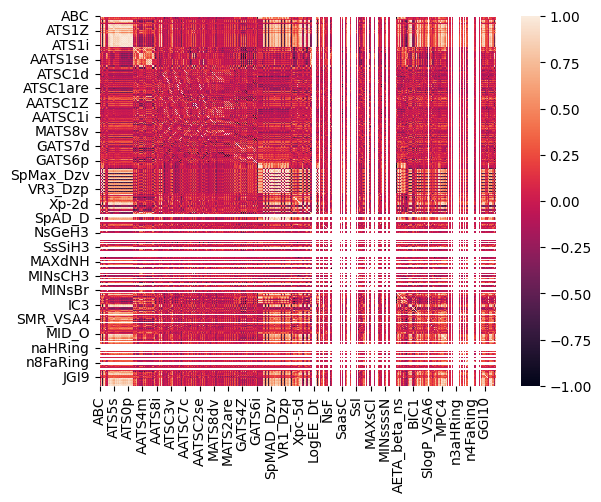

In [142]:
sns.heatmap(corr_matrix)

In [143]:
len(corr_matrix)

1614

In [144]:
corr_matrix.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,Label
ABC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABCGG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nAcid,NaN,NaN,1.000000,0.067982,-0.316990,-0.549546,-0.557298,-0.316990,-0.563080,-0.538711,...,0.008421,0.001565,-0.036315,0.650633,-0.062863,-0.030791,-0.044953,0.070244,0.004425,-0.118973
nBase,NaN,NaN,0.067982,1.000000,-0.137096,-0.079617,-0.101403,-0.137096,-0.139657,-0.192157,...,0.115452,-0.003913,0.217765,0.172257,-0.021150,-0.002861,0.024603,-0.108678,-0.079548,-0.012396
SpAbs_A,NaN,NaN,-0.316990,-0.137096,1.000000,0.588290,0.560761,1.000000,0.491464,0.794838,...,0.750816,0.807700,-0.229300,-0.411623,0.846410,0.850082,0.850772,0.747166,0.828476,0.239161


In [145]:
# corr_matrix = corr_matrix.dropna(subset=['IC50'])
# sorted_corr_matrix = corr_matrix.sort_values(by='IC50', ascending=False)
# index_order = sorted_corr_matrix.index.tolist()
# sorted_corr_matrix = sorted_corr_matrix[index_order].reindex(index_order)
corr_matrix = corr_matrix.dropna(subset=['Label'])
sorted_corr_matrix = corr_matrix.sort_values(by='Label', ascending=False)
index_order = sorted_corr_matrix.index.tolist()
sorted_corr_matrix = sorted_corr_matrix[index_order].reindex(index_order)

In [146]:
sorted_corr_matrix.head()

,Label,MATS4d,IC2,AATSC4d,EState_VSA3,GATS8d,nSpiro,TIC1,IC3,TIC2,...,GATS4dv,SIC0,SM1_Dzv,AATSC8d,RNCG,ATSC8d,MATS8d,VE2_A,GATS4d,RPCG
Label,1.000000,0.335539,0.328910,0.324058,0.308983,0.304973,0.302705,0.298063,0.297881,0.295344,...,-0.222655,-0.225305,-0.231245,-0.242027,-0.244469,-0.245612,-0.248159,-0.259922,-0.282250,-0.296927
MATS4d,0.335539,1.000000,0.214184,0.990802,0.329712,0.621487,0.223563,0.347537,0.370460,0.344705,...,-0.471757,-0.409230,-0.417589,-0.611236,-0.504789,-0.339154,-0.626948,-0.354637,-0.813300,-0.280254
IC2,0.328910,0.214184,1.000000,0.195648,0.482069,0.410974,0.325533,0.838300,0.855110,0.808640,...,-0.157225,-0.403923,-0.482869,-0.236227,-0.563994,-0.202787,-0.252203,-0.701191,-0.043223,-0.706886
AATSC4d,0.324058,0.990802,0.195648,1.000000,0.325974,0.619828,0.219465,0.345105,0.356517,0.344789,...,-0.452110,-0.442337,-0.418654,-0.648914,-0.512985,-0.324836,-0.658053,-0.350807,-0.799311,-0.258019
EState_VSA3,0.308983,0.329712,0.482069,0.325974,1.000000,0.360929,0.201909,0.557987,0.481667,0.530172,...,-0.071614,-0.338947,-0.549399,-0.298945,-0.500905,-0.212781,-0.306292,-0.423459,-0.150774,-0.520172


<Axes: >

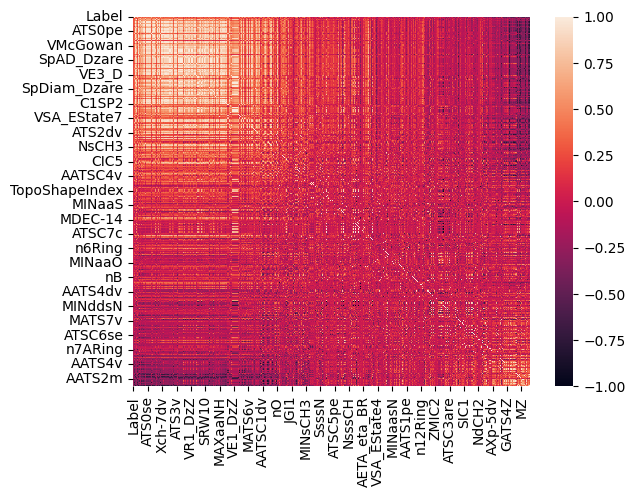

In [147]:
sns.heatmap(sorted_corr_matrix)

In [122]:
len(sorted_corr_matrix)

1354

In [148]:
# ic50_corrs_abs = sorted_corr_matrix['IC50'].abs()
# features = sorted_corr_matrix.loc[ic50_corrs_abs > 0.05, :].index.tolist()
# sorted_corr_matrix = sorted_corr_matrix.loc[features, features]
# sorted_corr_matrix = sorted_corr_matrix.iloc[(-sorted_corr_matrix['IC50'].abs()).argsort()]
ic50_corrs_abs = sorted_corr_matrix['Label'].abs()
features = sorted_corr_matrix.loc[ic50_corrs_abs > 0.05, :].index.tolist()
sorted_corr_matrix = sorted_corr_matrix.loc[features, features]
sorted_corr_matrix = sorted_corr_matrix.iloc[(-sorted_corr_matrix['Label'].abs()).argsort()]

sorted_corr_matrix = corr_matrix.sort_values(by='Label', ascending=False)
index_order = sorted_corr_matrix.index.tolist()
sorted_corr_matrix = sorted_corr_matrix[index_order].reindex(index_order)

<Axes: >

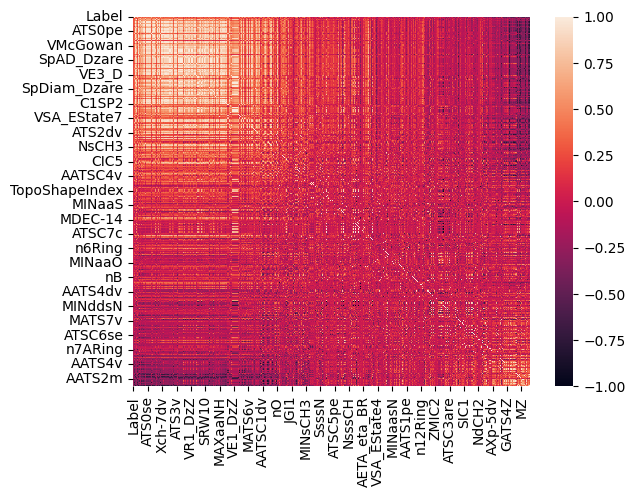

In [149]:
sns.heatmap(sorted_corr_matrix)

In [150]:
sorted_corr_matrix.head()

,Label,MATS4d,IC2,AATSC4d,EState_VSA3,GATS8d,nSpiro,TIC1,IC3,TIC2,...,GATS4dv,SIC0,SM1_Dzv,AATSC8d,RNCG,ATSC8d,MATS8d,VE2_A,GATS4d,RPCG
Label,1.000000,0.335539,0.328910,0.324058,0.308983,0.304973,0.302705,0.298063,0.297881,0.295344,...,-0.222655,-0.225305,-0.231245,-0.242027,-0.244469,-0.245612,-0.248159,-0.259922,-0.282250,-0.296927
MATS4d,0.335539,1.000000,0.214184,0.990802,0.329712,0.621487,0.223563,0.347537,0.370460,0.344705,...,-0.471757,-0.409230,-0.417589,-0.611236,-0.504789,-0.339154,-0.626948,-0.354637,-0.813300,-0.280254
IC2,0.328910,0.214184,1.000000,0.195648,0.482069,0.410974,0.325533,0.838300,0.855110,0.808640,...,-0.157225,-0.403923,-0.482869,-0.236227,-0.563994,-0.202787,-0.252203,-0.701191,-0.043223,-0.706886
AATSC4d,0.324058,0.990802,0.195648,1.000000,0.325974,0.619828,0.219465,0.345105,0.356517,0.344789,...,-0.452110,-0.442337,-0.418654,-0.648914,-0.512985,-0.324836,-0.658053,-0.350807,-0.799311,-0.258019
EState_VSA3,0.308983,0.329712,0.482069,0.325974,1.000000,0.360929,0.201909,0.557987,0.481667,0.530172,...,-0.071614,-0.338947,-0.549399,-0.298945,-0.500905,-0.212781,-0.306292,-0.423459,-0.150774,-0.520172


In [151]:
len(sorted_corr_matrix)

1353

In [153]:
sorted_corr_matrix.to_excel("../output/corr_matrix/corr_matrix_before_filter_with_label_pcc.xlsx")

In [154]:
# upper_triangle = pd.DataFrame(0, index=sorted_corr_matrix.index, columns=sorted_corr_matrix.columns)
upper_triangle = sorted_corr_matrix.where(np.triu(np.ones(sorted_corr_matrix.shape)).astype(bool))

<Axes: >

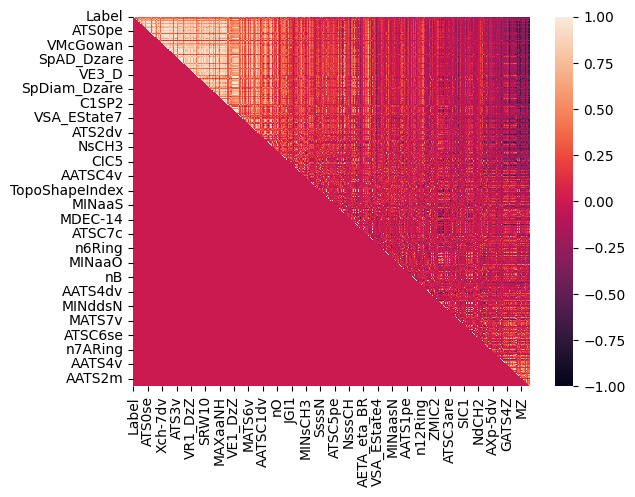

In [155]:
upper_triangle = upper_triangle.fillna(0)
sns.heatmap(upper_triangle)

In [156]:
def set_zero_diagonal(sorted_corr_matrix):
    col_idx = 0
    arr = []
    for index, row in sorted_corr_matrix.iterrows():
        row.iloc[col_idx] = 0
        col_idx+=1
    return sorted_corr_matrix

upper_triangle = set_zero_diagonal(upper_triangle)

In [157]:
len(upper_triangle)

1353

In [158]:
upper_triangle.head()

,Label,MATS4d,IC2,AATSC4d,EState_VSA3,GATS8d,nSpiro,TIC1,IC3,TIC2,...,GATS4dv,SIC0,SM1_Dzv,AATSC8d,RNCG,ATSC8d,MATS8d,VE2_A,GATS4d,RPCG
Label,0.0,0.335539,0.328910,0.324058,0.308983,0.304973,0.302705,0.298063,0.297881,0.295344,...,-0.222655,-0.225305,-0.231245,-0.242027,-0.244469,-0.245612,-0.248159,-0.259922,-0.282250,-0.296927
MATS4d,0.0,0.000000,0.214184,0.990802,0.329712,0.621487,0.223563,0.347537,0.370460,0.344705,...,-0.471757,-0.409230,-0.417589,-0.611236,-0.504789,-0.339154,-0.626948,-0.354637,-0.813300,-0.280254
IC2,0.0,0.000000,0.000000,0.195648,0.482069,0.410974,0.325533,0.838300,0.855110,0.808640,...,-0.157225,-0.403923,-0.482869,-0.236227,-0.563994,-0.202787,-0.252203,-0.701191,-0.043223,-0.706886
AATSC4d,0.0,0.000000,0.000000,0.000000,0.325974,0.619828,0.219465,0.345105,0.356517,0.344789,...,-0.452110,-0.442337,-0.418654,-0.648914,-0.512985,-0.324836,-0.658053,-0.350807,-0.799311,-0.258019
EState_VSA3,0.0,0.000000,0.000000,0.000000,0.000000,0.360929,0.201909,0.557987,0.481667,0.530172,...,-0.071614,-0.338947,-0.549399,-0.298945,-0.500905,-0.212781,-0.306292,-0.423459,-0.150774,-0.520172


In [159]:
upper_triangle.to_excel("../output/corr_matrix/HDAC2_upper_triangle_with_label.xlsx")

In [160]:
def remove_correlated_features(sorted_df, pcc_point):
    above_pcc_point = (sorted_df > pcc_point) | (sorted_df < -pcc_point)
    shapes = [] 
    features = []
    dropped_features = set()
    for idx, row in sorted_df.iterrows():
        if idx in dropped_features:
            continue
        print("[+] Working with row: " + idx)
        cols_rows_to_drop = []
        for col in sorted_df.columns:
            if above_pcc_point.loc[idx, col]:
                cols_rows_to_drop.append(col)
        # drop the columns
        print("[-] Detected in this row:")
        print(cols_rows_to_drop)
        for col_row_index in cols_rows_to_drop:
            dropped_features.add(col_row_index)
        #Drop the data
        sorted_df = sorted_df.drop(cols_rows_to_drop, axis=1).drop(cols_rows_to_drop, axis=0)
        shapes.append(sorted_df.shape)
        features.append(sorted_df.index.to_list())  
        # check if there are any rows left
        if len(sorted_df) == 0:
            break
    return sorted_df, shapes, features

In [161]:
pcc_point = 0.75
matrix_before_processing = upper_triangle.iloc[1:, 1:]
result_matrix, shapes, features = remove_correlated_features(matrix_before_processing, pcc_point=pcc_point)

[+] Working with row: MATS4d
[-] Detected in this row:
['AATSC4d', 'ATSC4d', 'AATSC5v', 'MATS5v', 'GATS5v', 'GATS4d']
[+] Working with row: IC2
[-] Detected in this row:
['TIC1', 'IC3', 'TIC2', 'TIC3', 'TIC0', 'VAdjMat', 'SRW02', 'TSRW10', 'MWC02', 'SRW04', 'MWC03', 'IC1']
[+] Working with row: EState_VSA3
[-] Detected in this row:
[]
[+] Working with row: GATS8d
[-] Detected in this row:
['GATS8i', 'GATS7d', 'AATS8d', 'GATS8dv', 'AATSC8dv', 'MATS8dv', 'AATSC8d', 'MATS8d']
[+] Working with row: nSpiro
[-] Detected in this row:
['Xch-5dv', 'Xch-5d', 'Xch-6dv', 'C4SP3', 'Xch-6d', 'Xch-4dv', 'MDEC-24', 'Xch-4d', 'SRW03', 'n3Ring', 'n3ARing', 'Xch-7dv', 'Xch-3d', 'Xch-3dv']
[+] Working with row: VR3_A
[-] Detected in this row:
['ETA_eta_L', 'SpMAD_Dzm', 'SpMAD_DzZ', 'SpMAD_Dzse', 'SpMAD_Dzpe', 'SpMAD_Dzare', 'SpMAD_Dzi', 'SpMAD_D', 'SpMAD_Dzv', 'SpMAD_Dzp', 'SpMax_Dzm', 'LogEE_Dzm', 'SpMax_DzZ', 'LogEE_DzZ', 'ETA_beta_s', 'SpAbs_Dzm', 'SpAD_Dzm', 'SpAD_DzZ', 'SpAbs_DzZ', 'ETA_eta_RL', 'SpM

In [162]:
len(result_matrix)

322

In [163]:
result_features = result_matrix.columns.to_list()
lengths = []
features_to_file = []
tmp_features = []
for features in result_features:
    tmp_features.append(features)
    lengths.append(len(tmp_features))
    features_to_file.append(tmp_features.copy())

In [86]:
processed_pcc_matrix_fp = "../output/pcc_processed_matrix/"+str(pcc_point)+"_pcc_processed_matrix_with_labels.xlsx"
shapes_and_features_fp = "../output/shapes_and_features/"+str(pcc_point)+"_shapes_and_features_with_labels.xlsx"
#Write to file processed pcc matrix
result_matrix['IC50'] = upper_triangle.iloc[0]
result_matrix.to_excel(processed_pcc_matrix_fp, index=True)

# create a DataFrame with the shapes and features
df_shapes = pd.DataFrame({'Len': lengths, 'Features': features_to_file})
# write the DataFrame to an Excel file
df_shapes.to_excel(shapes_and_features_fp, index=False)

## Choosing the optimal features

### Read from features file

In [43]:
# features_data = pd.read_excel('../output/shapes_and_features.xlsx', sheet_name='Sheet1')
# features_strings = features_data['Features']

In [45]:
# import ast
# list_of_features = []
# for features_string in features_strings:
#     list_of_features.append(ast.literal_eval(features_string))

# features = list_of_features[0]
# len(list_of_features[0])

In [154]:
# authors_features = ['Xc-4dv', 'MATS4s', 'GATS1dv', 'SdssC', 'BCUTd-1h', 'GATS1s', 'GATS1are', 'AATSC3d'
#                     , 'PEOE_VSA2', 'AATS4v', 'AATS4Z', 'GATS3d', 'MATS3m', 'AXp-5dv', 'EState_VSA4',
#                     'ETA_eta_L', 'ATSC5m', 'RotRatio', 'SsNH2', 'ETA_epsilon_5', 'SlogP_VSA2',
#                     'MID_N', 'EState_VSA5', 'Xc-5dv', 'JGI5', 'GATS5pe', 'AATSC4d']
authors_features = ['nSpiro', 'C4SP3', 'GATS8s', 'n5ARing', 'SssCH2', 'nARing', 'Xpc-5dv', 'ATSC3d', 'Xc-4dv', 'ATSC5d', 'SMR_VSA4', 'GATS8se', 'n5AHRing', 'MDEC-24', 'ATSC6v', 'GATS2d', 'n6ARing', 'ATSC3v', 'nAHRing', 'ATSC6m', 'nHRing', 'ATSC2d', 'PEOE_VSA7', 'Xc-3dv', 'SMR_VSA6', 'GATS4dv', 'MATS4s']
len(authors_features)

27

In [155]:
X_train = train_modred_descriptors[authors_features]
X_test = test_mordred_descriptors[authors_features]
print(X_train.columns)
print(X_test.columns)
print(len(X_train.columns))

Index(['nSpiro', 'C4SP3', 'GATS8s', 'n5ARing', 'SssCH2', 'nARing', 'Xpc-5dv',
       'ATSC3d', 'Xc-4dv', 'ATSC5d', 'SMR_VSA4', 'GATS8se', 'n5AHRing',
       'MDEC-24', 'ATSC6v', 'GATS2d', 'n6ARing', 'ATSC3v', 'nAHRing', 'ATSC6m',
       'nHRing', 'ATSC2d', 'PEOE_VSA7', 'Xc-3dv', 'SMR_VSA6', 'GATS4dv',
       'MATS4s'],
      dtype='object')
Index(['nSpiro', 'C4SP3', 'GATS8s', 'n5ARing', 'SssCH2', 'nARing', 'Xpc-5dv',
       'ATSC3d', 'Xc-4dv', 'ATSC5d', 'SMR_VSA4', 'GATS8se', 'n5AHRing',
       'MDEC-24', 'ATSC6v', 'GATS2d', 'n6ARing', 'ATSC3v', 'nAHRing', 'ATSC6m',
       'nHRing', 'ATSC2d', 'PEOE_VSA7', 'Xc-3dv', 'SMR_VSA6', 'GATS4dv',
       'MATS4s'],
      dtype='object')
27


In [156]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_np = sc.fit_transform(X_train)
X_test_np = sc.transform(X_test)
X_train = pd.DataFrame(X_train_np, columns = X_train.columns)
X_test = pd.DataFrame(X_test_np, columns = X_test.columns)

<Axes: >

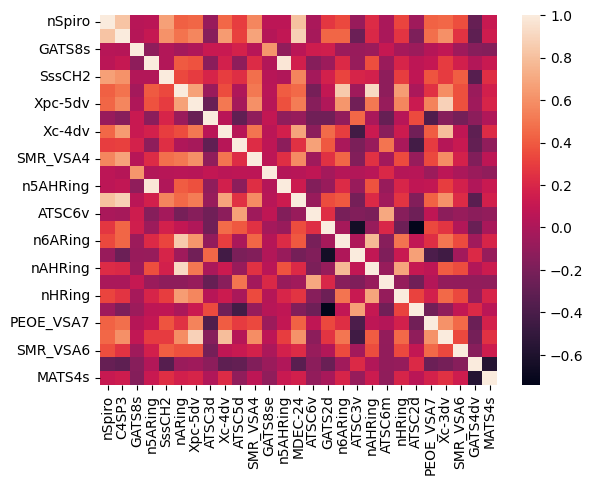

In [157]:
sns.heatmap(X_train.corr())

In [158]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(787, 27)
(787,)
(197, 27)
(197,)


## 2.3. Xây dựng mô hình

#### Random Forest Classifier

In [159]:
from sklearn.ensemble import RandomForestClassifier
rf_des_author = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_des_author.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

#### K-nearest neighbors

In [160]:
from sklearn.neighbors import KNeighborsClassifier
knn_des_author = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_des_author.fit(X_train, y_train)

KNeighborsClassifier()

#### Support Vector Machine

In [161]:
from sklearn.svm import SVC
svm_des_author = SVC(kernel='rbf', probability=True, random_state=0)
svm_des_author.fit(X_train, y_train)

SVC(probability=True, random_state=0)

#### XGBoost

In [162]:
from xgboost import XGBClassifier
bst_des_author = XGBClassifier(n_estimators=100, objective='binary:logistic')
bst_des_author.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# 3. Đánh giá mô hình

### 10-fold-cross validation

In [163]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [164]:
X_Total = np.concatenate((X_train, X_test), axis=0)
y_Total = np.concatenate((y_train, y_test), axis=0)

In [165]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

scores = cross_val_score(knn_des_author, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(rf_des_author, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(svm_des_author, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(bst_des_author, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))

Độ chính xác của 10-fold cross validation: 0.711 (0.038)
Độ chính xác của 10-fold cross validation: 0.754 (0.040)
Độ chính xác của 10-fold cross validation: 0.713 (0.046)
Độ chính xác của 10-fold cross validation: 0.752 (0.040)


### Accuracy, Sensitivity, Specificity

In [166]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate
import math

In [167]:
def model_evaluation_calculation(cm):
    tp = cm[0][0]; tn = cm[1][1]; fp = cm[0][1]; fn = cm[1][0]
    ac = (tp+tn)/(tp+tn+fp+fn)
    se = tp/(tp+fn)
    sp = tn/(tn+fp)
    mcc = (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return ac, se, sp, mcc

In [168]:
def me_result(cm):
    print("Confusion matrix:")
    print(cm)
    ac, se, sp, mcc = model_evaluation_calculation(cm)
    print("Comparision:")
    table = [[' ' 'Accuracy', 'Sensitity', 'Specificity', 'MCC'], ['My model', ac, se, sp, mcc]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

KNN

In [169]:
#KNN
y_knn_pred = knn_des_author.predict(X_test)
cm = confusion_matrix(y_test, y_knn_pred)
me_result(cm)

Confusion matrix:
[[67 26]
 [36 68]]
Comparision:
╒══════════╤═════════════╤═════════════╤═══════════════╤══════════╕
│          │    Accuracy │   Sensitity │   Specificity │      MCC │
╞══════════╪═════════════╪═════════════╪═══════════════╪══════════╡
│ My model │    0.685279 │    0.650485 │      0.723404 │ 0.374083 │
╘══════════╧═════════════╧═════════════╧═══════════════╧══════════╛


RF

In [170]:
#SVM
y_rf_pred = rf_des_author.predict(X_test)
cm = confusion_matrix(y_test, y_rf_pred)
me_result(cm)

Confusion matrix:
[[75 18]
 [25 79]]
Comparision:
╒══════════╤═════════════╤═════════════╤═══════════════╤══════════╕
│          │    Accuracy │   Sensitity │   Specificity │      MCC │
╞══════════╪═════════════╪═════════════╪═══════════════╪══════════╡
│ My model │    0.781726 │        0.75 │      0.814433 │ 0.565249 │
╘══════════╧═════════════╧═════════════╧═══════════════╧══════════╛


SVM

In [171]:
#SVM
y_svm_pred = svm_des_author.predict(X_test)
cm = confusion_matrix(y_test, y_svm_pred)
me_result(cm)

Confusion matrix:
[[81 12]
 [39 65]]
Comparision:
╒══════════╤═════════════╤═════════════╤═══════════════╤══════════╕
│          │    Accuracy │   Sensitity │   Specificity │      MCC │
╞══════════╪═════════════╪═════════════╪═══════════════╪══════════╡
│ My model │    0.741117 │       0.675 │      0.844156 │ 0.507429 │
╘══════════╧═════════════╧═════════════╧═══════════════╧══════════╛


XGboost

In [172]:
y_bst_pred = bst_des_author.predict(X_test)
cm = confusion_matrix(y_test, y_bst_pred)
me_result(cm)

Confusion matrix:
[[75 18]
 [26 78]]
Comparision:
╒══════════╤═════════════╤═════════════╤═══════════════╤══════════╕
│          │    Accuracy │   Sensitity │   Specificity │      MCC │
╞══════════╪═════════════╪═════════════╪═══════════════╪══════════╡
│ My model │     0.77665 │    0.742574 │        0.8125 │ 0.555763 │
╘══════════╧═════════════╧═════════════╧═══════════════╧══════════╛


### AUC

In [173]:
from sklearn.metrics import roc_auc_score
knn_y_proba = knn_des_author.predict_proba(X_test)[:, 1]
rf_y_proba = rf_des_author.predict_proba(X_test)[:, 1]
svm_y_proba = svm_des_author.predict_proba(X_test)[:, 1]
bst_y_proba = bst_des_author.predict_proba(X_test)[:, 1]


knn_auc_score = roc_auc_score(y_test, knn_y_proba)
rf_auc_score = roc_auc_score(y_test, rf_y_proba)
svm_auc_score = roc_auc_score(y_test, svm_y_proba)
bst_auc_score = roc_auc_score(y_test, bst_y_proba)
print(knn_auc_score, rf_auc_score, svm_auc_score, bst_auc_score)

0.7697994210090985 0.8443961952026469 0.789185277088503 0.8507030603804797


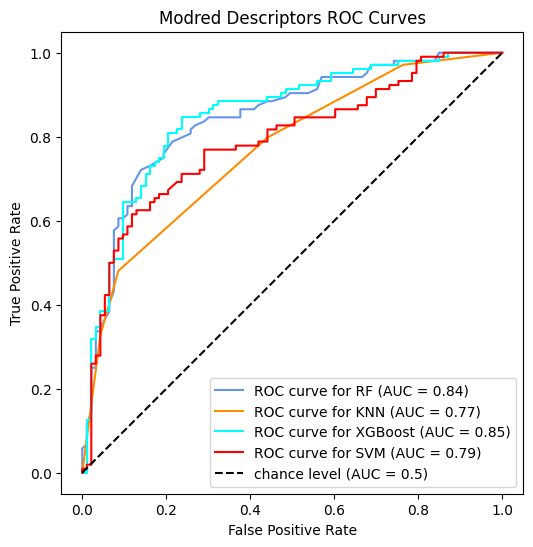

In [174]:
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_estimator(
    estimator=rf_des_author, 
    X=X_test, 
    y=y_test,
    name=f"ROC curve for RF",
    color='cornflowerblue',
    ax=ax)


RocCurveDisplay.from_estimator(
    estimator=knn_des_author, 
    X=X_test, 
    y=y_test,
    name=f"ROC curve for KNN",
    color='darkorange',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=bst_des_author, 
    X=X_test, 
    y=y_test,
    name=f"ROC curve for XGBoost",
    color='aqua',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=svm_des_author, 
    X=X_test, 
    y=y_test,
    name=f"ROC curve for SVM",
    color='red',
    ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Modred Descriptors ROC Curves")
plt.legend()
plt.show()